In [303]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import tqdm

import cvxpy as cp

In [304]:
class Quantizer(nn.Module):
    def __init__(self, 
                 initial_codebook:torch.Tensor,
                 H: torch.Tensor,
                 Weights: torch.Tensor,
                 ):
        """Vector Quantizer

        Args:
            initial_codebook (torch.Tensor): the initial codebook (n,k)
            H (torch.Tensor): the Hessian of shape (n,n)
            Weights (torch.Tensor): weights of shape (n,n)
        """
        super(Quantizer, self).__init__()

        # self.codebook = nn.Parameter(initial_codebook, requires_grad=True)
        self.codebook = nn.Parameter(initial_codebook)
        self.H = H
        self.Weights = Weights
        n,k = initial_codebook.shape
        #randomly initialize the initial assignments through xavier uniform initialization
        #a matrix of shape (k,n)

        #logistic initialization
        initial_assignments = torch.empty(k,n,device = initial_codebook.device,
                                                            dtype = initial_codebook.dtype
                                                            ).uniform_(0,1)
        

        self.initial_assignments = nn.Parameter(#take the logistic of the initial assignments
                                                torch.log(initial_assignments / (1 - initial_assignments)),
                                                requires_grad = True
                                                )

        self.activation = nn.PReLU().to(initial_codebook.device)
        # self.initial_assignments = torch.empty(n,k,device = initial_codebook.device,
        #                                                     dtype = initial_codebook.dtype
        #                                                     ).uniform_(-1,1)

        print(self.H.dtype,self.Weights.dtype,self.codebook.dtype,self.initial_assignments.dtype)


    def sparse_penalty(self, assignments: torch.Tensor, target_sparsity:float, 
                       greater_penalty:float):
        """Penalty function for the assignments

        Args:
            assignments (torch.Tensor): the assignments of shape (k,n)
                assumed to be past through 
            target_sparsity (float): the target sparsity of the assignments, sparsity is column wise
            greater_penalty (float): the penalty for greater sparsity
            lesser_penalty (float): the penalty for lesser sparsity

        Returns:
            torch.Tensor: the penalty
        """
        sparsity = torch.sum(assignments, dim = 0) #shape (n,)
        sparsity = sparsity / assignments.shape[0]
        penalty = torch.relu(sparsity - target_sparsity)
        return torch.sum(greater_penalty * penalty), torch.sum(assignments)

    def penalty(self, assignments, beta, penalty_1_weight,
                penalty_2_weight):
        """Penalty function for the assignments

        Args:
            assignments (torch.Tensor): the assignments of shape (k,n)
                assumed to be past through 
            beta (float): a hyperparameter for the first penalty, this penalty
            is 1- |2*a_ij - 1|**(beta)

            penalty_1_weight (float): the weight of the first penalty
            penalty_2_weight (float): the weight of the second penalty
            this penalty is the sum of the assignments, therefore enforceing 
            sparsity

        Returns:
            torch.Tensor: the penalty
        """
        # assert torch.isfinite(torch.abs(2*assignments - 1)).all()
        penalty_1 = torch.sum(1 - torch.abs(2*assignments - 1)**beta)
        # print(penalty_1)
        # penalty_2, sparsity = self.sparse_penalty(assignments, 0.5, 1)
        # return penalty_1_weight * penalty_1 + penalty_2_weight * penalty_2, penalty_1, sparsity
        penalty_2 = torch.sum(assignments)
        # print(penalty_2)
        return penalty_1_weight * penalty_1 + penalty_2_weight * penalty_2, penalty_1, penalty_2
    
    def forward(self,beta,penalty_1_weight,
                penalty_2_weight):
        """Forward pass of the quantizer

        Args:
            beta (float): a hyperparameter for the first penalty, this penalty
            is 1- |2*a_ij - 1|**(beta)

            penalty_1_weight (float): the weight of the first penalty
            penalty_2_weight (float): the weight of the second penalty
            this penalty is the sum of the assignments, therefore enforceing 
            sparsity

        Returns:
            torch.Tensor: the quantized codebook
        """
        #get the assignments
        assignments = torch.sigmoid(self.initial_assignments)*1.2 - 0.1
        # print(assignments)
        # assert torch.isfinite(assignments).all()
        assignments = torch.clip(assignments,0,1)
        # assert torch.isfinite(assignments).all()

        #get the quantized_weights
        quantized_weights = self.codebook @ assignments
        assert torch.isfinite(quantized_weights).all()
        #get the difference between the quantized weights and the original weights
        diff = quantized_weights - self.Weights

        #get the loss
        loss = torch.einsum('ik,kl,il->', diff, self.H, diff)
        # assert torch.isclose(loss,torch.sum(diff**2))
        # loss = torch.sum(diff**2)
        #get the penalty
        penalty,p1,p2 = self.penalty(assignments, beta, penalty_1_weight, penalty_2_weight)
        # assert torch.isfinite(penalty)
        return loss + penalty, loss, penalty,p1,p2
    
    def get_rounded_error(self):

        #get the assignments
        assignments = torch.sigmoid(self.initial_assignments)*1.2 - 0.1
        assignments = torch.clip(assignments,0,1)
        assignments = torch.round(assignments)  
        #get the quantized_weights
        quantized_weights = self.codebook @ assignments

        #get the difference between the quantized weights and the original weights
        diff = quantized_weights - self.Weights

        #get the loss
        # loss = torch.einsum('ik,kl,il->', diff, self.H, diff)
        # assert torch.isclose(loss,torch.sum(diff**2))
        # loss = torch.sum(diff**2)
        loss = torch.einsum('ik,kl,il->', diff, self.H, diff)
        return loss
    
    def update_codebook(self):
        raise NotImplementedError
        with torch.no_grad():
            assignments = torch.sigmoid(self.initial_assignments)

            #cast to numpy
            assignments = assignments.cpu().numpy()
            weights = self.Weights.cpu().numpy()
            H = self.H.cpu().numpy()

            #use cvxpy to solve the optimization problem
            k,n = assignments.shape
            codebook = cp.Variable(self.codebook.shape)
            objective = cp.Minimize(cp.trace((weights - codebook @ assignments).T @ H @ (weights - codebook @ assignments)))
            constraints = []
            
            #no constraints
            prob = cp.Problem(objective, constraints)
            prob.solve()
            self.codebook = torch.tensor(codebook.value,device = self.codebook.device,dtype = self.codebook.dtype)
            
        return self.codebook

    def update_assignments(self):
        raise NotImplementedError
        #closed form update 
        with torch.no_grad():
            # assignments = self.initial_assignments
            # print(assignments.shape)
            #update formula for the assignments is
            #A = W^T C (C^T C)^-1

            codebook_inner_product = self.codebook.T @ self.H @ self.codebook
            inverse = torch.inverse(codebook_inner_product)

            self.initial_assignments = self.Weights @ self.H @ self.codebook @ inverse
            print(self.initial_assignments)
            assert torch.all(torch.isfinite(self.initial_assignments))
        
        #take the mean of the assignments
        mean = torch.mean(torch.abs(self.initial_assignments))
        #rescale the assignments
        self.initial_assignments = self.initial_assignments / mean
        #scale up the codebook
        self.codebook = self.codebook * mean



In [305]:
data = torch.load("/home/lliu/huffman/test/original_weights.pt")
weights = data['weights'].float().to(torch.device("cuda:6"))
H = data['H'].float().to(torch.device("cuda:6"))

In [ ]:
# def BetaScheduler_(i, T, scale, bias):

#     signal = (np.sin(((i%T)/T-0.5)*np.pi)+1)*0.5

#     return scale * signal + bias

# def BetaScheduler_(i, T, scale, bias):

#     signal = (np.sin(((i)/T)*np.pi)+1) - 1

#     return scale * signal + bias

def BetaScheduler_(i, T, scale, bias):

    # signal = (np.sin(((i%T)/T-0.5)*np.pi)+1)*0.5
    signal = (T-i)/T
    # signal = (np.cos(((i)/T)*np.pi*2))*0.5+0.5
    return scale * signal + bias

# def BetaScheduler_(i, T, scale, bias):

#     # signal = (np.sin(((i%T)/T-0.5)*np.pi)+1)*0.5
#     # signal = abs((i-T/2)*2/T)**5
#     signal = (i/T)**5
#     return scale * signal + bias

import matplotlib.pyplot as plt 

k = 256

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#try to initalize the codebook from the eigenvectors of the weights
eigenvalues, eigenvectors = torch.linalg.eigh(weights)
print(eigenvalues.shape, eigenvectors.shape)
# eigenvectors = eigenvalues.vectors
indexs = torch.argsort(eigenvalues,descending=True)[:k]
#renormalize the eigenvectors
initial_codebook = eigenvectors[indexs,:].T / k
print(initial_codebook.shape)
quantizer = Quantizer(
                        # weights[indexs,:].T/k
                        initial_codebook
                    #   , torch.eye(H.shape[0],device = H.device,dtype = H.dtype)
                    , H
                      , weights)


n_iters = 10000
n_subiters = 10000
n_subiters_multiple = 1.1

beta_min, beta_max = 1, 4

penalty_1_weight = 1
penalty_2_weight = 1
penalty_2_multiple = 1 
 
beta = 5 
penalty_2_weight = 0.01

losses = []
rounded_errors = []
i_s = []

errors = []
penalties = []
binary_penalty = []
sparsity_penalty = []
betas = []
penalty_2_weights = []
lrs = []


optimizer = torch.optim.Adam([{'params': quantizer.codebook, 'lr': 5e-4},
                                {'params': quantizer.initial_assignments, 'lr': 1e-3}])
# scheduler_up = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
# scheduler_down = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.005)

j = 0
prev_loss = float('inf')
patience_up = 25
patience_down = 25
impatience_1 = 0
impatience_2 = 0


for i in tqdm.tqdm(range(n_iters)):
    beta = BetaScheduler_(j, n_subiters, beta_max - beta_min, beta_min)
    # penalty_2_weight = BetaScheduler_(j, n_subiters*penalty_2_multiple, 0.2, 0.0)
    # print(beta)
    # print(beta)
    loss, loss1, loss2, p1, p2 = quantizer(beta, penalty_1_weight, penalty_2_weight)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print(loss)

    assert torch.all(torch.isfinite(loss))

    losses.append(loss.item())
    errors.append(loss1.item())
    penalties.append(loss2.item())
    binary_penalty.append(p1.item())
    sparsity_penalty.append(p2.item())
    betas.append(beta)
    penalty_2_weights.append(penalty_2_weight)
    j+=1
    if i % 1000 == 0:
        # print(f"Loss: {loss.item()}, Error: {loss1.item()/torch.sum(torch.abs(weights**2))}, Loss2: {loss2.item()}, P1: {p1.item()}, sparsity: {p2.item()/(H.shape[0]*k)}, beta: {beta}, penalty_2_weight: {penalty_2_weight}")
        print(f"Loss: {loss.item()}, Error: {loss1.item()/H.shape[0]}, Loss2: {loss2.item()}, P1: {p1.item()}, sparsity: {p2.item()/(H.shape[0]*k)}, beta: {beta}, penalty_2_weight: {penalty_2_weight}")
        # wandb.log({"Loss": loss.item(), "Error": loss1.item()/H.shape[0], "Penalty": loss2.item(), "BinaryPenalty": p1.item(), "Sparsity": p2.item()/(H.shape[0]**2),
        #            "penalty_2_weight": penalty_2_weight, "beta": beta})
        fig = plt.figure()
        plt.hist(np.clip(torch.sigmoid(quantizer.initial_assignments).detach().cpu().numpy().flatten()*1.2-0.1,0,1), bins = 100,density = True)
        plt.xlim(0,1)
        plt.ylim(1e-5,1)
        plt.yscale('log')
        plt.title("Assignments")
        plt.savefig(f"test/assignments{i}.png")  
        plt.close(fig)  

        rounded_error = quantizer.get_rounded_error()
        rounded_errors.append(rounded_error.item())
        i_s.append(i)
        # print(f"Rounded Error: {rounded_error.item()/torch.sum(torch.abs(weights**2))}")
        print(f"Rounded Error: {rounded_error.item()/H.shape[0]}")
    if j % n_subiters == n_subiters - 1:
        n_subiters = int(n_subiters * n_subiters_multiple)
        j = 0
        impatience_1 = 0

    # if loss1.item() > prev_loss:
    #     impatience_1 += 1
    #     if impatience_1 > patience_up:
    #         scheduler_up.step()
    #         # print("Decreasing learning rate to ", scheduler_up.get_last_lr())
    #         impatience_1 = 0
    # if loss1.item() < prev_loss:
    #     impatience_2 += 1
    #     if impatience_2 > patience_down:
    #         scheduler_down.step()
    #         # print("Increasing learning rate to ", scheduler_down.get_last_lr())
    #         impatience_2 = 0 

    prev_loss = loss1.item()

    lrs.append(optimizer.param_groups[0]['lr'])

    

print(loss1.item()/H.shape[0], loss2.item(), p1.item(), p2.item()/(H.shape[0]**2))



In [ ]:
1/1.0001


In [ ]:
plt.plot(errors[100:])
plt.plot(i_s[1:],rounded_errors[1:])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.array(losses)/losses[0], label = "total loss")
plt.plot(np.array(errors)/errors[0], label = "error")
plt.plot(np.array(penalties)/penalties[0], label = "penalty")
plt.plot(np.array(binary_penalty)/binary_penalty[0], label = "binary penalty")
plt.plot(np.array(sparsity_penalty)/sparsity_penalty[0], label = "sparsity penalty")
plt.legend()
plt.yscale('log')

In [ ]:
plt.plot(np.array(sparsity_penalty)/(H.shape[0]*k))

In [ ]:
plt.plot(np.array(betas)/np.max(betas), label = "beta")
plt.plot(np.array(pe|nalty_2_weights)/np.max(penalty_2_weights), label = "penalty_2_weight")

In [ ]:
i = np.arange(1000)
T = 1000
plt.plot((np.cos(((i)/T)*np.pi*2))*0.5+0.5)
# (np.sin(((i)/T)*np.pi)+1)*0.5

In [ ]:
errors[-1]

In [ ]:
min(errors)/weights.shape[0]

In [ ]:
#get the assignments
assignments = torch.sigmoid(quantizer.initial_assignments)*1.2 - 0.1
assignments = torch.clip(assignments,0,1)
# assignments = torch.round(assignments)
print(assignments)
#round the assignments
# assignments = torch.round(assignments)
print(assignments)
#get the quantized_weights
quantized_weights = quantizer.codebook @ assignments
print(quantized_weights)
#get the difference between the quantized weights and the original weights
diff = quantized_weights - quantizer.Weights
print(quantizer.Weights)
print(torch.mean(torch.abs(diff**2))/torch.mean(torch.abs(quantizer.Weights**2)))
# print(diff)

In [ ]:
torch.einsum('ik,kl,il->', diff, quantizer.H, diff)/(quantizer.Weights.shape[0])


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(torch.round(torch.sigmoid(quantizer.initial_assignments)).detach().cpu().numpy(),interpolation='nearest', aspect='auto')
#scale it to be a square image
#add a colorbar
plt.colorbar()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(torch.sigmoid(quantizer.initial_assignments).detach().cpu().numpy()*1.2-0.1,interpolation='nearest', aspect='auto')
#scale it to be a square image
#add a colorbar
plt.colorbar()
plt.show()


In [ ]:
torch.sum(assignments,dim = 0)/k

In [ ]:
plt.hist(assignments.detach().cpu().numpy().flatten(),bins=100)
# plt.yscale('log')

In [ ]:
a = assignments.detach().cpu().numpy().flatten()

plt.plot(np.sort(a), np.linspace(0,1,len(a)))

In [ ]:
import matplotlib.pyplot as plt
import glob


#create a gif from soem figures

import imageio

images = []
for fn in sorted(glob.glob("test/*.png")):
    images.append(imageio.imread(fn))
print(len(images))
imageio.mimsave('test.gif', images)


In [ ]:
print(quantizer.Weights)

In [14]:
import torch
from torch import nn, optim

# Example large model split into two parts
class LargeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.part1 = nn.Sequential(nn.Linear(1000, 1000), nn.ReLU(), nn.Linear(1000, 1000))
        self.part2 = nn.Sequential(nn.Linear(1000, 1000), nn.ReLU(), nn.Linear(1000, 10))

    def forward(self, x):
        x = self.part1(x)
        x = self.part2(x)
        return x

# Instantiate the model
model = LargeModel()

# Assign parts of the model to different GPUs
device1 = torch.device("cuda:0")
device2 = torch.device("cuda:1")

model.part1.to(device1)
model.part2.to(device2)

# Optimizers for each part of the model
optimizer1 = optim.SGD(model.part1.parameters(), lr=0.01)
optimizer2 = optim.SGD(model.part2.parameters(), lr=0.01)

# Example input and target
input_data = torch.randn(64, 1000).to(device1)
target = input_data[:,:10]**2
target = target.to(device2)
# Loss function
criterion = nn.CrossEntropyLoss()

# Forward pass
output_part1 = model.part1(input_data)        # Compute part1 on GPU 0
output_part1 = output_part1.to(device2)       # Transfer activations to GPU 1
# output_part1.retain_grad()                    # Retain gradients for backpropagation
output = model.part2(output_part1)            # Compute part2 on GPU 1

# Compute loss
# print(output, target)
loss = criterion(output, target)

# Backward pass
loss.backward()                               # Backpropagate from GPU 1
output_part1_grad = output_part1.grad.to(device1)  # Transfer gradients to GPU 0
optimizer2.step()                             # Update parameters for part2
optimizer2.zero_grad()
print(output_part1_grad)
# Continue backward pass on GPU 0
output_part1.backward(output_part1_grad)      # Backpropagate through part1
optimizer1.step()                             # Update parameters for part1
optimizer1.zero_grad()

# Clear GPU memory
torch.cuda.empty_cache()


/tmp/ipykernel_2198241/2399002648.py:49: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  output_part1_grad = output_part1.grad.to(device1)  # Transfer gradients to GPU 0


AttributeError: 'NoneType' object has no attribute 'to'

In [67]:
import torch
from torch import nn, optim

# Define a large model with two partitions
class LargeModel(nn.Module):
    def __init__(self,input_size, output_size): 
        super().__init__()
        self.part1 = nn.Sequential(nn.Linear(input_size, 1000), nn.ReLU(), nn.Linear(1000, 1000))
        self.part2 = nn.Sequential(nn.ReLU(), nn.Linear(1000, output_size))
    
    def forward_part1(self, x):
        return self.part1(x)
    
    def forward_part2(self, x):
        return self.part2(x)
    
    def forward(self, x):
        x = self.forward_part1(x)
        x = self.forward_part2(x)
        return x

# Instantiate the model
model = LargeModel(1,1)
device = torch.device("cuda:7")  # Single GPU

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Manual Partitioning Workflow
def forward_backward_manual(input_data, target, criterion):
    # Move part1 to GPU
    model.part1.to(device)
    input_data = input_data.to(device)
    
    # Forward pass through part1
    intermediate = model.forward_part1(input_data)
    
    # Move part1 back to CPU to free memory
    model.part1.to("cpu")
    torch.cuda.empty_cache()
    
    # Move part2 to GPU
    model.part2.to(device)
    intermediate_values = intermediate.clone().detach().requires_grad_(True)
    intermediate.to("cpu")
    
    # Forward pass through part2
    output = model.forward_part2(intermediate_values)
    
    # Compute loss
    target = target.to(device)
    loss = criterion(output, target)
    
    # Backward pass through part2
    loss.backward()

    # print(intermediate_values.grad)
    # raise NotImplementedError
    
    # Move part2 back to CPU to free memory
    model.part2.to("cpu")
    grad_keep = intermediate_values.grad.clone()
    intermediate_values.to("cpu")
    torch.cuda.empty_cache()
    

    # Move part1 back to GPU for backward pass
    # print(intermediate.grad)
    model.part1.to(device)
    intermediate.to(device)
    intermediate.backward(grad_keep)  # Backward through part1

    # Update parameters
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

# Example usage
input_data = torch.randn(100, 1)
fn = lambda x: torch.sin(x)
target = fn(input_data)

criterion = nn.MSELoss()

# Training step

for _ in range(100):
    loss = forward_backward_manual(input_data, target, criterion)
    print(f"Loss: {loss}")

Loss: 0.32434219121932983
Loss: 1.5600860118865967
Loss: 0.25419846177101135
Loss: 0.16643700003623962
Loss: 0.45280444622039795
Loss: 0.39094817638397217
Loss: 0.17928974330425262
Loss: 0.03611570596694946
Loss: 0.020241662859916687
Loss: 0.07807030528783798
Loss: 0.12591275572776794
Loss: 0.12145406752824783
Loss: 0.07714996486902237
Loss: 0.029748214408755302
Loss: 0.008412993513047695
Loss: 0.017759351059794426
Loss: 0.039502762258052826
Loss: 0.05200333893299103
Loss: 0.04808347672224045
Loss: 0.03281133994460106
Loss: 0.015831150114536285
Loss: 0.0050367009826004505
Loss: 0.003289426676928997
Loss: 0.0081290602684021
Loss: 0.014550039544701576
Loss: 0.01823667623102665
Loss: 0.017323782667517662
Loss: 0.012575904838740826
Loss: 0.006577337626367807
Loss: 0.0024120279122143984
Loss: 0.0017641001613810658
Loss: 0.003943785559386015
Loss: 0.006777748465538025
Loss: 0.00833420641720295
Loss: 0.007915263064205647
Loss: 0.005928944796323776
Loss: 0.0033806769642978907
Loss: 0.001428410

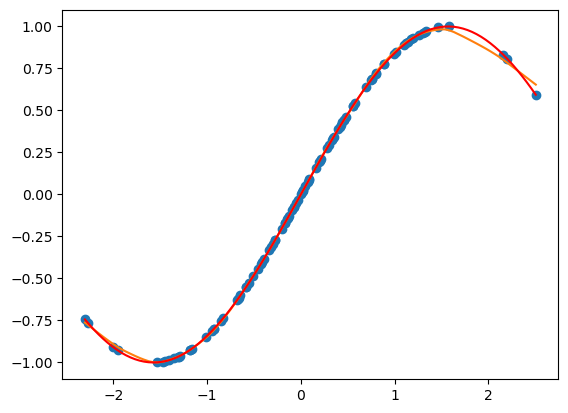

In [68]:
import matplotlib.pyplot as plt

plt.plot(input_data.detach().cpu().numpy(), target.detach().cpu().numpy(), 'o')

x = torch.linspace(torch.min(input_data),torch.max(input_data),100).reshape(-1,1)
model.to("cpu")
y_target = fn(x)
y = model(x).detach().cpu().numpy()
plt.plot(x.cpu().numpy(), y)
plt.plot(x.cpu().numpy(), y_target.cpu().numpy(), 'r')

In [33]:
# Instantiate the model
model = LargeModel(1,1)
device = torch.device("cuda:7")  # Single GPU

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

for _ in range(100):
    output = model(input_data)
    loss = criterion(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())

2.8958933353424072
2.900325059890747
1.4935258626937866
0.4889121949672699
0.40388885140419006
0.5391551852226257
0.49618303775787354
0.2941880226135254
0.09974351525306702
0.02735009416937828
0.0840713232755661
0.17726299166679382
0.20794624090194702
0.1591680496931076
0.0827343761920929
0.03432105481624603
0.03185631334781647
0.05750611424446106
0.08222845941781998
0.08736351132392883
0.07153196632862091
0.04581703618168831
0.024716360494494438
0.016855599358677864
0.0211232490837574
0.029118327423930168
0.03256360813975334
0.02894776500761509
0.021734628826379776
0.016213271766901016
0.01520300842821598
0.017678266391158104
0.02038605511188507
0.02042566053569317
0.01710822992026806
0.012089740484952927
0.008116073906421661
0.007117605302482843
0.008852270431816578
0.011157728731632233
0.011645324528217316
0.009535453282296658
0.006106610409915447
0.0034924643114209175
0.003011173103004694
0.004348323214799166
0.00605732062831521
0.0067146853543818
0.005841369740664959
0.00405721971

In [65]:
import torch.nn.functional as F
x = torch.ones(2,1).requires_grad_()
y = F.linear(x, torch.eye(1))   

(y[0]**2 + y[1]).backward()
print(x.grad)


tensor([[2.],
        [1.]])


In [66]:
class a:
    def __init__(self):
        self.a = ["1","2","3"]

a = a()
b = a.a 

b = b[::-1]
print(a.a)
print(b)

['1', '2', '3']
['3', '2', '1']


In [3]:
import torch


state_dict = torch.load("../quantized_models/llama-2-7b/2bpv/quantized/layer_0.pt")

In [ ]:
n_params = 0
for k,v in state_dict.items():
    if isinstance(v, torch.FloatTensor):
        n_params += v.numel()
        print(k,v.numel())
print(n_params)

self_attn.q_proj.original_bias 4096
self_attn.q_proj.quantizer.norms_1 4096
self_attn.q_proj.quantizer.norms_0 4096
self_attn.q_proj.quantizer.codebook 1024
self_attn.q_proj.quantizer.codes 4194304
self_attn.k_proj.original_bias 4096
self_attn.k_proj.quantizer.norms_1 4096
self_attn.k_proj.quantizer.norms_0 4096
self_attn.k_proj.quantizer.codebook 1024
self_attn.k_proj.quantizer.codes 4194304
self_attn.v_proj.original_bias 4096
self_attn.v_proj.quantizer.norms_1 4096
self_attn.v_proj.quantizer.norms_0 4096
self_attn.v_proj.quantizer.codebook 1024
self_attn.v_proj.quantizer.codes 4194304
self_attn.o_proj.original_bias 4096
self_attn.o_proj.quantizer.norms_1 4096
self_attn.o_proj.quantizer.norms_0 4096
self_attn.o_proj.quantizer.codebook 1024
self_attn.o_proj.quantizer.codes 4194304
mlp.gate_proj.original_bias 11008
mlp.gate_proj.quantizer.norms_1 11008
mlp.gate_proj.quantizer.norms_0 4096
mlp.gate_proj.quantizer.codebook 1024
mlp.gate_proj.quantizer.codes 11272192
mlp.up_proj.original_b

In [6]:
codes

NameError: name 'codes' is not defined